# RIP.ie daily death data (v2)

* rip.ie
* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [2]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)

In [60]:
def get_data(dups=False):
    
    df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    return df

df = get_data()
df = df[df.year>=2008]

449109


## get male/female

In [61]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
male=list(pd.read_csv('male_names.csv')['name'].str.lower())
u=[]
def check_name(x):
    """try to detect sex"""
    
    notice=str(x.notice).lower()
    mr=['son of','husband of']
    for n in mr:
        if n in notice:
            return 'M'
    fr=['wife of','daughter of']
    for n in fr:
        if n in notice:
            return 'F' 
    if 'convent' in notice or 'wife of' in notice:
        return 'F'
    kwds = ['loving','home','residence','family','parents','heartbroken',
            'son','daughter','remains','wife','partner']
    for n in kwds:
        if 'his '+n in notice:
            return 'M'
        elif 'her '+n in notice:
            return 'F'
    name=x['name']
    if type(name) is float:
        return
    if 'née' in name:
        return 'F'
    #print (x)
    s = name.split()
    s = [i.strip("()").strip(',').lower() for i in s]
    #print (s)
    for n in s:
        if len(n)<=1:
            continue
        if n in female:
            return 'F'
        elif n in male:
            return 'M'            
    #print (s)
    u.extend(s)
    return 'U'

df['sex'] = df.apply(check_name,1)
df.sex.value_counts()

M    211928
F    203555
U      1599
Name: sex, dtype: int64

In [86]:
df[df.sex=='U'].to_csv('unknown.csv')

In [39]:
pd.DataFrame(u).drop_duplicates().to_csv('unknown_names.csv',index=False)

In [62]:
df = df[df.year<2022]

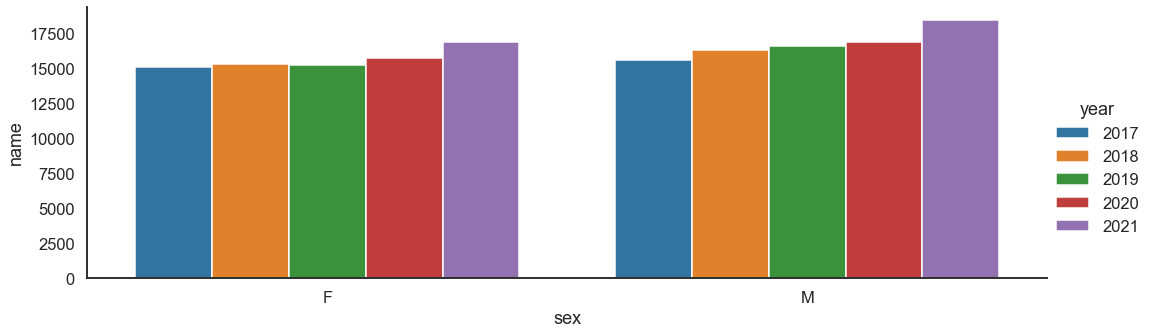

In [67]:
sub=df[df.sex!='U']
g=sub.groupby(['year','sex']).agg({'name':np.size}).reset_index()
g = g[(g.year>2016) & (g.year<2022)]
#print (g)
sns.catplot(data=g,x='sex',y='name',hue='year',kind='bar',aspect=3.0)
plt.savefig('ireland_deaths_ripie_bysex.png',dpi=150)

            date sex  year  deaths
5114  2015-01-01   F  2015      49
5115  2015-01-01   M  2015      36
5116  2015-01-02   F  2015      46
5117  2015-01-02   M  2015      49
5118  2015-01-03   F  2015      46
...          ...  ..   ...     ...
10223 2021-12-29   M  2021      48
10224 2021-12-30   F  2021      53
10225 2021-12-30   M  2021      54
10226 2021-12-31   F  2021      60
10227 2021-12-31   M  2021      57

[5114 rows x 4 columns]


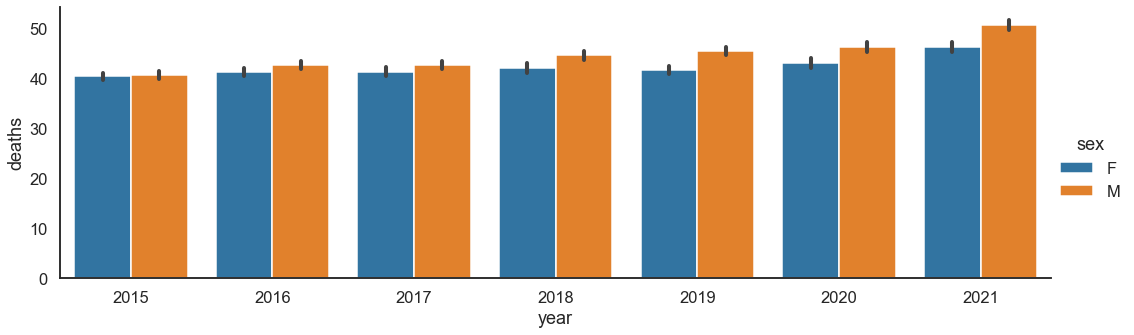

In [65]:
sub=df[df.sex!='U']
g=pd.DataFrame(sub.groupby(['date','sex','year']).size(),columns=['deaths']).reset_index()
g = g[(g.year>2014) & (g.year<2022)]
sns.catplot(data=g,x='year',y='deaths',hue='sex',kind='bar',aspect=3.0) 

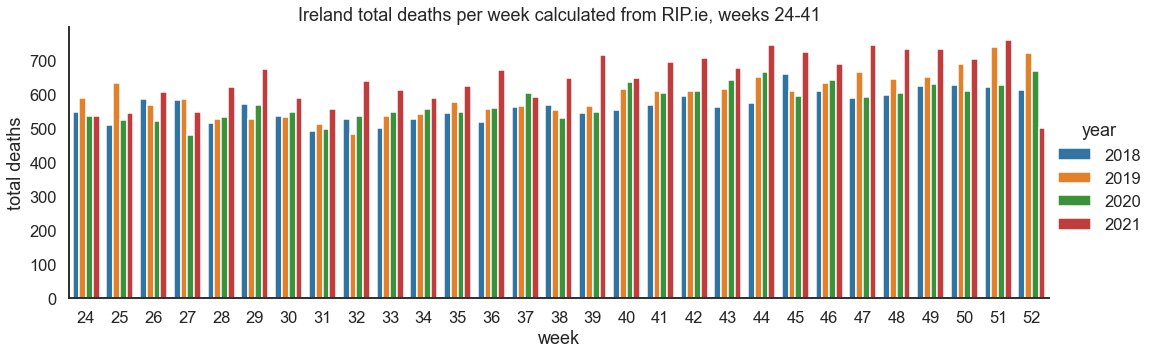

In [14]:
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>23) & (g.week<=52)]
g = g[(g.year>2017) & (g.year<2022)]
#print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0)
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks 24-41')
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

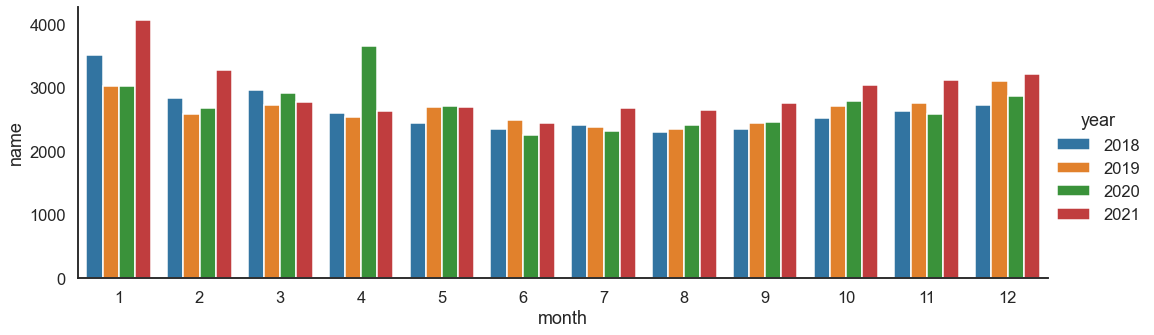

In [64]:
g=df.groupby(['year','month']).agg({'name':np.size}).reset_index()
g = g[(g.year>2017) & (g.year<2022)]
sns.catplot(data=g,x='month',y='name',hue='year',kind='bar',aspect=3.0)
plt.savefig('ireland_deaths_ripie_bymonth_v2.png',dpi=150)

In [8]:
nhomes = pd.read_csv('nursing_homes.csv')
#print (nhomes[:10])

def find_nhome(x):
    for i,r in nhomes.iterrows():
        if r.shortname in x.notice and x.county == r.county:
            return r['name']+','+r.county

x=df[:160]
#x['home'] = x.apply(lambda x: find_nhome(x),1)
#print (x)

In [43]:
pop = pd.read_csv('ireland_population.csv')
wbcdrt = pd.read_csv('ireland_cdrt.csv')

year
2008    27612
2009    27948
2010    27614
2011    25727
2012    26823
2013    27957
2014    28477
2015    29681
2016    30776
2017    30705
2018    31677
2019    31819
2020    32719
2021    35387
dtype: int64


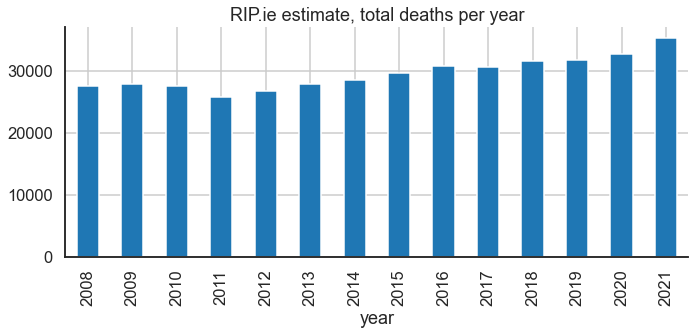

In [46]:
x=df#[(df.month<=12) & (df.month>5)]
totals = x.groupby('year').agg('size')
print (totals)
ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths per year')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

In [ ]:
#x['deathsper1000'] = d.deaths/d['pop']*1e3

,year,pop,deaths,deathsper1000
13,2008,4485100,27612,6.156384
12,2009,4533400,27948,6.164909
11,2010,4554800,27614,6.062615
10,2011,4574900,25727,5.623511
9,2012,4585400,26823,5.849653
8,2013,4593100,27957,6.086739
7,2014,4609600,28477,6.177759
6,2015,4652425,29681,6.379684
5,2016,4695779,30776,6.553971
4,2017,4753279,30705,6.459751


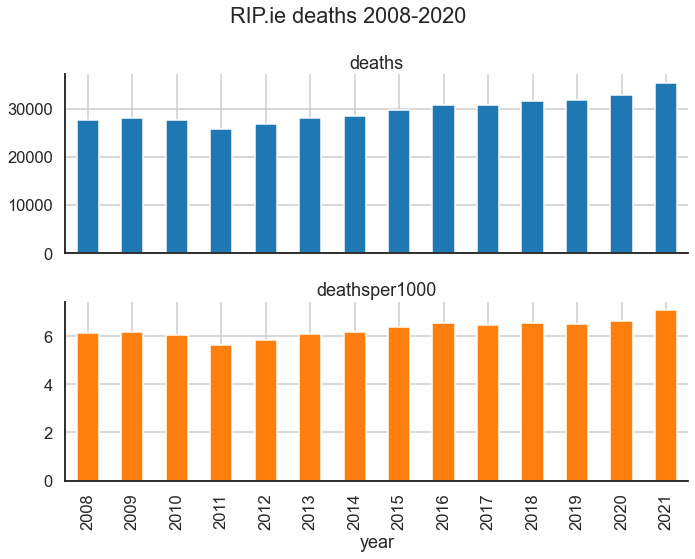

In [71]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.deaths/d['pop']*1e3
#d=wbcdrt.merge(d,on='year')
d.plot(x='year',y=['deaths','deathsper1000'],kind='bar',subplots=True,grid=True,legend=False,figsize=(10,8))
plt.suptitle('RIP.ie deaths 2008-2020')
sns.despine()
plt.tight_layout()
d

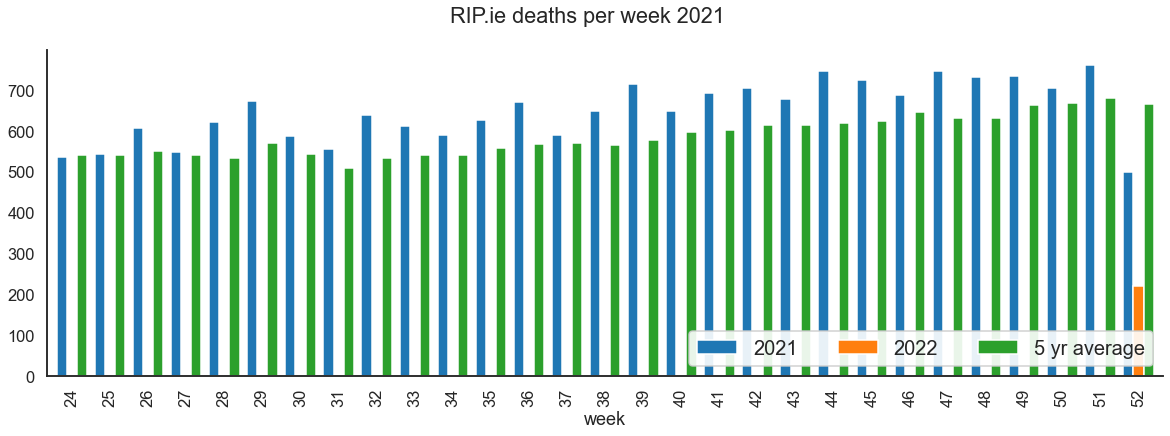

In [37]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[23:52,13:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=20)
plt.suptitle('RIP.ie deaths per week 2021')
sns.despine()
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

In [ ]:
x = df.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=2,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for y in range(2008,2021):
    ax.vlines(pd.to_datetime('%s-12-31' %y),0,160,color='r',ls=':')

plt.suptitle('RIP.ie deaths 2013-2021, 14 day average')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend_v2.png',dpi=150)

449109


/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


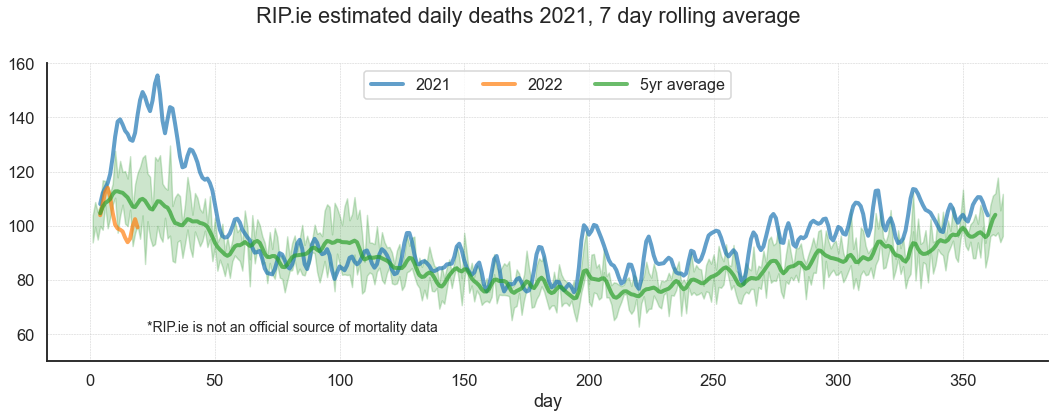

In [57]:
df = get_data()
df = df[df.year>=2008]
byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
byday['5yr average'] = byday.iloc[:,8:-1].mean(1)
#x = byday.iloc[:,:9]

x = byday[[2021,2022,'5yr average']]
#x = x.loc[50:]
x.loc[364:,2021] = np.nan
win=7
meanday = x.rolling(window=win,win_type='hamming',center=True).mean()
ax=meanday.plot(figsize=(15,6),ylim=(50,160),lw=4,alpha=0.7)
ave=x['5yr average']
sd=byday.iloc[:,8:-1].std(1)

ax.fill_between(ave.index, ave-(sd/2), ave+(sd/2), color='green', alpha=0.2)
ax.grid(linestyle='--',linewidth=.5)
plt.legend(loc=9,ncol=3,fontsize=16)
sns.despine()
plt.suptitle('RIP.ie estimated daily deaths 2021, %s day rolling average' %win)
plt.tight_layout()
plt.text(0.1,0.1,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
plt.savefig('ireland_deaths_ripie_compared_mean_v2.png',dpi=150)

## GRO compare

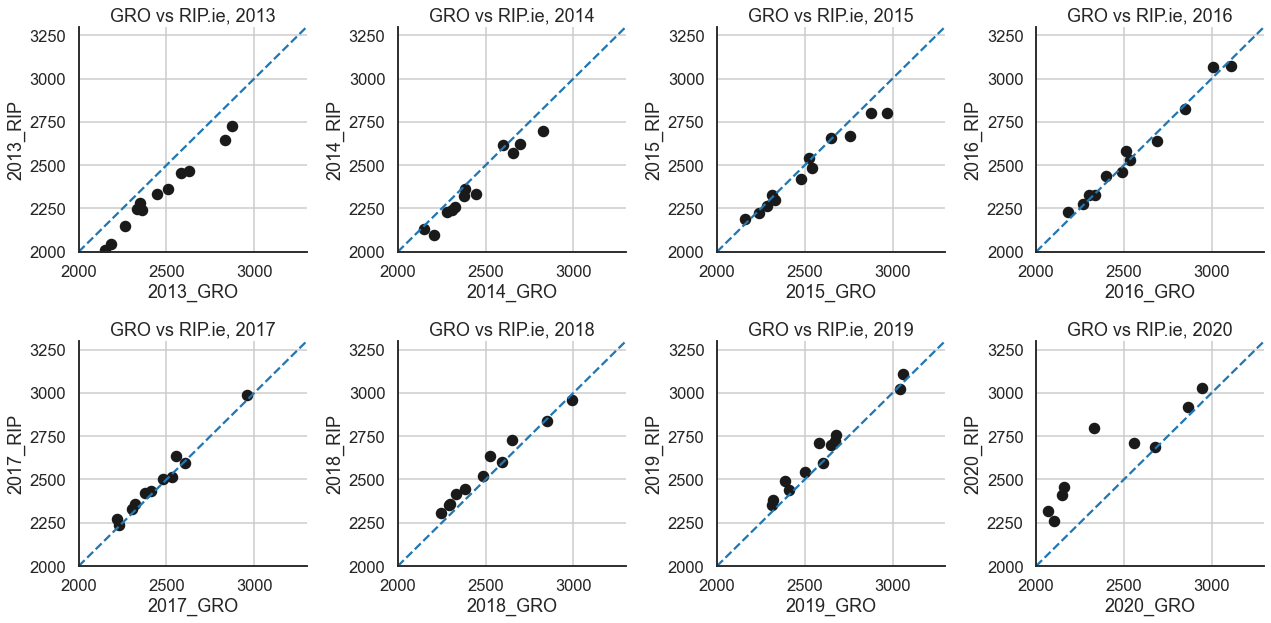

In [40]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

In [12]:
eu=pd.read_csv('estat_demo_r_mwk_ts_filtered.tsv',sep='\t').T
eu.columns=['Eurostat']

In [ ]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
#print (x[-20:])
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
#print (x[-20:])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')

## CSO RIP

CSO's estimates can be accessed via their Pxstat system [here](https://data.cso.ie/product/MFPDA). See also https://www.cso.ie/en/releasesandpublications/in/vs/informationnoteonthepublicationofmortalityfiguresusingpublicdatasources/

In [ ]:
cr1=pd.read_csv('RIP02.20220126T230157.csv')
cr1['date'] = pd.to_datetime(cr1.Day)
cr1
fig,ax=plt.subplots(1,1,figsize=(17,7))
#ax=cr1.groupby('Sex').plot(x='date',y='VALUE',lw=3,ax=ax,grid=True)

In [30]:
cso=pd.read_csv('RIP02.20220126T230118.csv')
cso['date'] = pd.to_datetime(cso.Day)

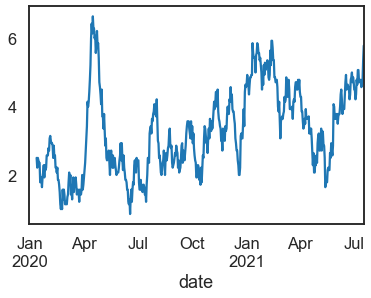

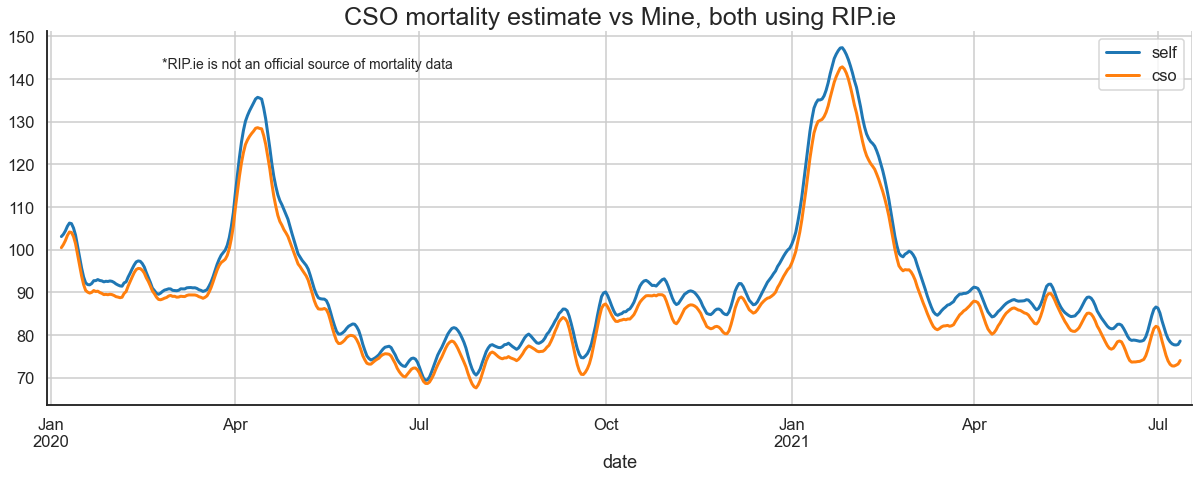

In [85]:
x = pd.DataFrame(df.groupby('date').size(),columns=['deaths']).reset_index()
x=x.merge(cso,on='date',how='right').set_index('date')
x=x[['deaths','VALUE']]
(x.deaths-x.VALUE).rolling(window=win).mean().plot()
x.columns=['self','cso']
win=14
x=x.rolling(window=win,win_type='hamming',center=True).mean()

fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
plt.title('CSO mortality estimate vs Mine, both using RIP.ie',fontsize=25)
plt.text(0.1,0.9,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig.savefig('cso_ireland_deaths_compared.png')

In [79]:
agep=pd.read_csv('EY002.20220127T230103.csv')
agep=agep[(agep.Sex=='Both sexes') &(agep['Age Group']!='All ages')]
agep['total']=agep.groupby('CensusYear')["VALUE"].transform('sum')
agep['ratio']=agep.VALUE/agep.total
agep

,Statistic,CensusYear,Age Group,Sex,UNIT,VALUE,total,ratio
3,Population at Each Census from 1926 to 2016,1926,0 - 14 years,Both sexes,Number,867879,2971992,0.292019
6,Population at Each Census from 1926 to 2016,1926,15 - 24 years,Both sexes,Number,526418,2971992,0.177126
9,Population at Each Census from 1926 to 2016,1926,25 - 44 years,Both sexes,Number,743545,2971992,0.250184
12,Population at Each Census from 1926 to 2016,1926,45 - 64 years,Both sexes,Number,562470,2971992,0.189257
15,Population at Each Census from 1926 to 2016,1926,65 years and over,Both sexes,Number,271680,2971992,0.091413
...,...,...,...,...,...,...,...,...
273,Population at Each Census from 1926 to 2016,2016,0 - 14 years,Both sexes,Number,1006552,4761865,0.211378
276,Population at Each Census from 1926 to 2016,2016,15 - 24 years,Both sexes,Number,576452,4761865,0.121056
279,Population at Each Census from 1926 to 2016,2016,25 - 44 years,Both sexes,Number,1406291,4761865,0.295324
282,Population at Each Census from 1926 to 2016,2016,45 - 64 years,Both sexes,Number,1135003,4761865,0.238353
